# **Basic Feature Engineering in Keras**

**Learning Objectives**
1. Create an input pipeline using `tf.data`
2. Engineer features to create categorical, crossed, and numerical feature columns

## **Introduction**

In this lab, we utilise feature engineering to improve the prediction of housing prices using a Keras sequential model.

Start by importing the necessary libraries for this lab

In [1]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

print("TensorFlow version", tf.__version__)

TensorFlow version 2.4.1


Many of the Google ML courses programming exercises use the [California Housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), which contains data drawn from the 1990 U.S. Census.

Let's read in the data set and create a Pandas DataFrame.

In [2]:
# `head()` function is used to get the first n rows of the DataFrame
housing_df = pd.read_csv("data/housing.csv", error_bad_lines=False)
housing_df = housing_df.loc[~housing_df["total_bedrooms"].isnull(),:]
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can use `.describe()` to see some summary statistics for the numeric fields in our dataframe. Note, for example, the count rown and corresponding columns. The count shows 204033.000000 for all feature clumns. Thus, there are no missing values.

In [3]:
# `describe()` is used to get the statistical summary of the DataFrame
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## **Split the data set for ML**

The data set we loaded was a single CSV file. We will split this into train, validation and test sets.

In [4]:
# Let's split the data set into train, validation, and test sets
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

13076 train examples
3270 validation examples
4087 test examples


Now, we need to output the split files. We will specifically need the `test.csv` later for testing.

In [5]:
train.to_csv("data/housing-train.csv", encoding="utf8", index=False)

In [6]:
val.to_csv("data/housing-val.csv", encoding="utf8", index=False)

In [7]:
test.to_csv("data/housing-test.csv", encoding="utf8", index=False)

In [8]:
!head data/housing*.csv

==> data/housing.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.12,241400.0,NEAR BAY
-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY

==> data/housing-test.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-121.45,38.37,32.0,1441.0,261.0,629.0,249.0,4.451

## **Create an input pipeline using `tf.data`**

Next, we will wrap the DataFrames with `tf.data`. This will enable us to use feature columns as bridge to map from the columns in the Pandas DataFrame to features used to train the model.

In [9]:
# Here, we create an input pipeline using `tf.data`
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop("median_house_value")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

Next we initialise the training and validation Datasets.

In [10]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [11]:
train_ds

<BatchDataset shapes: ({longitude: (None,), latitude: (None,), housing_median_age: (None,), total_rooms: (None,), total_bedrooms: (None,), population: (None,), households: (None,), median_income: (None,), ocean_proximity: (None,)}, (None,)), types: ({longitude: tf.float64, latitude: tf.float64, housing_median_age: tf.float64, total_rooms: tf.float64, total_bedrooms: tf.float64, population: tf.float64, households: tf.float64, median_income: tf.float64, ocean_proximity: tf.string}, tf.float64)>

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

In [12]:
for feature_batch, label_batch in train_ds.take(1):
    print("Every feature:", list(feature_batch.keys()))
    print("A batch of households:", feature_batch["households"])
    print("A batch of ocean_proximity:", feature_batch["ocean_proximity"])
    print("A batch of targets:", label_batch)

Every feature: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
A batch of households: tf.Tensor(
[ 302.  226.  137.  440.  577.  380.  819.  270.  901.  338.  408.  379.
  311.  276.  922.  422.  412.  516.  281.   68.  532.  260. 1117.  280.
  517.  352.  391.  214.  607.  316.  554.  428.], shape=(32,), dtype=float64)
A batch of ocean_proximity: tf.Tensor(
[b'<1H OCEAN' b'INLAND' b'INLAND' b'<1H OCEAN' b'<1H OCEAN' b'INLAND'
 b'<1H OCEAN' b'<1H OCEAN' b'NEAR OCEAN' b'NEAR BAY' b'INLAND' b'INLAND'
 b'<1H OCEAN' b'INLAND' b'<1H OCEAN' b'<1H OCEAN' b'INLAND' b'<1H OCEAN'
 b'INLAND' b'<1H OCEAN' b'INLAND' b'<1H OCEAN' b'<1H OCEAN' b'INLAND'
 b'INLAND' b'NEAR OCEAN' b'INLAND' b'<1H OCEAN' b'INLAND' b'NEAR BAY'
 b'INLAND' b'<1H OCEAN'], shape=(32,), dtype=string)
A batch of targets: tf.Tensor(
[113600. 309100.  88500. 162800. 355300.  59400. 383800. 192400. 144200.
 186000.  90500.  90300. 5000

We can see that the Dataset returns a dictionary of column names (from the DataFrame) that map to column values from rows in the DataFrame.

### **Numeric columns**

The output of a `tf.feature_column` becomes the input to the model. A numeric is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the DataFrame unchanged.

In the California Housing Prices data set, most columns are numeric. Let's create a variable called `numeric_cols` to hold only the numerical feature columns.

In [13]:
# Let's create a variable called `numeric_cols` to hold only the numerical feature columns
numeric_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", 
                "total_bedrooms", "population", "households", "median_income"]

### **Scaler function**

It is very important for numerical variables to get scaled before they are *fed* into the neural network. Here we use *min-max scaling*. Here we are creating a function named `get_scal` which takes a list of numerical features and returns a `minmax` function, which will be used in `tf.feature_column.numeric_column()` as the `normalizer_fn` parameter. `minmax` function itself takes a *numerical* number from a particular feature and returns scaled value of that number.

Next, we scale the numerical feature columns that we assigned to the variable `numeric_cols`.

In [14]:
# `get_scal` function takes a list of numerical features and returns a `minmax` function
# `minmax` function itself takes a `numerical` number from a particular feature and returns scaled value of that number
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi - mini)
        return(minmax)

In [15]:
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(tf.feature_column.numeric_column(header,
                                                            normalizer_fn=scal_input_fn))

In [16]:
feature_columns

[NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

Next, we should validate the total number of feature columns. Compare this number to the number of numeric features you input earlier

In [17]:
print("Total number of feature columns:", len(feature_columns))

Total number of feature columns: 8


### **Using the Keras sequential model**

Next, we will compile and fit a Keras sequential model.

In [18]:
# Model creation
# `tf.keras.layers.DenseFeatures()` is a layer that produces a dense Tensor based on given `feature_columns`
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype="float64")

# `tf.keras.Sequential()` groups a linear stack of layers into a `tf.keras` model
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(12, input_dim=8, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="linear", name="median_house_value")
])

# Model compilation
model.compile(optimizer="adam",
              loss="mse",
              metrics=["mse"])

# Model fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
400/409 [============================>.] - ETA: 0s - loss: 54789961308.1600 - mse: 54789961308.1600WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

In [19]:
# Let's show loss as Mean Squared Error (MSE)
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

409/409 [==============================] - 1s 2ms/step - loss: 10850928640.0000 - mse: 10850928640.0000
Mean Squared Error 10850928640.0


### **Visualise the model loss curve**

Next, we will use matplotlib to draw the model's loss curves for training and validation. A line plot is also created showing the mean squared error loss over the training epochs for both the training (blue) and validation (orange) sets.

In [20]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))
    
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history["val_{}".format(key)])
        plt.title("model {}".format(key))
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(["train", "validation"], loc="upper left");

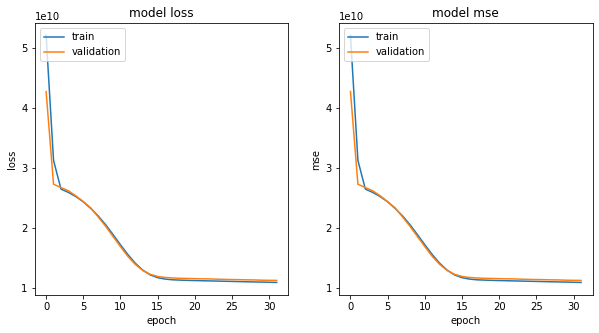

In [21]:
plot_curves(history, ["loss", "mse"])

### **Load test data**

Next, we read in the `test.csv` file and validate that there are no null_values.

Again, we can use `.describe()` to see some summary statistics for the numeric fields in our DataFrame. The count shows 4087.000000 for all feature columns. Thus, there are no missing values.

In [22]:
test_data = pd.read_csv("data/housing-test.csv")
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,-119.599090,35.655821,28.756056,2626.910692,536.308784,1419.136041,497.932713,3.859357,205400.682652
std,1.992921,2.130715,12.621488,2180.832129,418.464597,1084.833255,374.725975,1.880610,114404.529872
min,-124.300000,32.560000,1.000000,18.000000,3.000000,5.000000,3.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1462.000000,297.000000,779.000000,281.000000,2.545950,118700.000000
50%,-118.520000,34.260000,29.000000,2126.000000,431.000000,1161.000000,407.000000,3.542900,179100.000000
75%,-118.030000,37.730000,37.000000,3104.000000,641.500000,1730.000000,601.000000,4.734050,263350.000000
max,-114.570000,41.800000,52.000000,30450.000000,5033.000000,12873.000000,4490.000000,15.000100,500001.000000


Now that we have created an input pipeline using `tf.data` and compiled a Keras sequential model, we create the input function for the test data and to intialise the `test_predict` variable.

In [23]:
def test_input_fn(features, batch_size=256):
    """An input function for prediction"""
    # Convert the inputs to a Dataset without labels
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

In [24]:
test_predict = test_input_fn(dict(test_data))

### **Prediction: Linear Regression**

Before we begin to feature engineer our feature columns, we should predict the median house value. By predicting the median house value now as a baseline, we can then compare it with the median house value after feature engineering.

To predict with Keras, you simply call `model.predict()` and pass in the housing features you want to predict the `median_house_value` for.

Note: we are predicting the model locally.

In [25]:
# Use the model to do prediction with `model.predict()`
predicted_median_house_value = model.predict(test_predict)

Consider rewriting this model with the Functional API.


Next, we run two predictions in separate cells $-$ one where `ocean_proximity="INLAND"` and one where `ocean_proximity="NEAR_OCEAN"`.

In [31]:
# ocean_proximity = "INLAND"
model.predict({
    "longitude": tf.convert_to_tensor([-121.86]),
    "latitude": tf.convert_to_tensor([39.78]),
    "housing_median_age": tf.convert_to_tensor([12.0]),
    "total_rooms": tf.convert_to_tensor([7653.0]),
    "total_bedrooms": tf.convert_to_tensor([1578.0]),
    "population": tf.convert_to_tensor([3628.0]),
    "households": tf.convert_to_tensor([1494.0]),
    "median_income": tf.convert_to_tensor([3.0905]),
    "ocean_proximity": tf.convert_to_tensor(["INLAND"])
}, steps=1)

array([[217383.12]], dtype=float32)

In [33]:
# ocean_proximity = "NEAR OCEAN"
model.predict({
    "longitude": tf.convert_to_tensor([-122.43]),
    "latitude": tf.convert_to_tensor([37.63]),
    "housing_median_age": tf.convert_to_tensor([34.0]),
    "total_rooms": tf.convert_to_tensor([4135.0]),
    "total_bedrooms": tf.convert_to_tensor([687.0]),
    "population": tf.convert_to_tensor([2154.0]),
    "households": tf.convert_to_tensor([742.0]),
    "median_income": tf.convert_to_tensor([4.9732]),
    "ocean_proximity": tf.convert_to_tensor(["NEAR OCEAN"])
})

array([[234350.28]], dtype=float32)

The array returns a predicted value. What do these numbers mean? Let's compare this value to the test set.

## **Feature engineering $-$ categorical and numerical features**

Now we indicate which features will be used in the model.

Note: Be sure to bucketise `housing_median_age` and ensure that `ocean_proximity` is one-hot encoded. And, don't forget your numeric values!

In [39]:
numeric_cols = ["longitude", "latitude", "housing_median_age", 
                "total_rooms", "total_bedrooms",  "population", 
                "households", "median_income"]

bucketized_cols = ["housing_median_age"]

# Indicator columns, Categorical features
categorical_cols = ["ocean_proximity"]

Next, we scale the numerical, bucketised, and categorical feature columns that we assigned to the variables in the preceding cell.

In [40]:
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi - mini)
        return(minmax)

In [41]:
# All numerical features scaling
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(tf.feature_column.numeric_column(header,
                                                            normalizer_fn=scal_input_fn))

### **Categorical Feature**

In this data set, `ocean_proximity` is represented as a string. We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The `tf.feature_column.categorical_with_vocabulary_list()` method provides a way to represent strings as a one-hot encoded vector.

Next, we create a categorical feature using `ocean_proximity`.

In [43]:
for feature_name in categorical_cols:
    vocabulary = housing_df[feature_name].unique()
    categorical_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = tf.feature_column.indicator_column(categorical_c)
    feature_columns.append(one_hot)

### **Bucketised Feature**

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a home's age. Instead of representing the house age as a numeric column, we could split the home age into several buckets using a *bucketised column*. Notice the one-hot values below describe which age range each row matches.

Next we create a bucketised column using `housing_median_age`.

In [45]:
age = tf.feature_column.numeric_column("housing_median_age")

# Bucketised cols
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[10, 20, 30, 40, 50, 60, 80, 100])
feature_columns.append(age_buckets)

### **Feature Cross**

Combining features into a single feature, better known as [*feature crosses*](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features and encode non-linearity. Crossed features must be either bucketised continous features, or binary (one-hot encoded) categorical features.

Next, we create a feature cross of `housing_median_age` (bucketised) and `ocean_proximity` (one-hot encoded).

In [48]:
vocabulary = housing_df["ocean_proximity"].unique()
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list("ocean_proximity", vocabulary)

crossed_feature = tf.feature_column.crossed_column([age_buckets, ocean_proximity],
                                                   hash_bucket_size=1000)
crossed_feature = tf.feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Next, we should validate the total number of feature columns. Compare this number to the number of numeric features you input earlier.

In [49]:
print("Total number of feature columns:", len(feature_columns))

Total number of feature columns: 11


Next, we will compile and fit the Keras sequential model. This is the same model we ran earlier.

In [53]:
# Create model
# `tf.keras.layers.DenseFeatures()` is a layer that produces a dense Tensor based on given feature_columns
feature_layer = tf.keras.layers.DenseFeatures(feature_columns,
                                              dtype="float64")

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model
model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(12, input_dim=8, activation="relu"),
    layers.Dense(8, activation="relu"),
    layers.Dense(1, activation="linear", name="median_house_value")
])

# Compile model
model.compile(optimizer="adam",
              loss="mse",
              metrics=["mse"])

# Fit model
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=32)

Epoch 1/32
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
393/409 [===========================>..] - ETA: 0s - loss: 54989350833.8321 - mse: 54989350833.8321WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'longitude': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=float64>, 'latitude': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=float64>, 'housing_median_age': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'total_rooms': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=float64>, 'total_bedrooms': <tf.Tensor 'ExpandDims_7:0' shape=(None, 1) dtype=float64>, 'population': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=float64>, 'households': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=float64>, 'median_income': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=float64>, 'ocean_proximity': <tf.Tensor 'ExpandDims_5:0' sh

In [54]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

409/409 [==============================] - 1s 2ms/step - loss: 10585739264.0000 - mse: 10585739264.0000
Mean Squared Error 10585739264.0


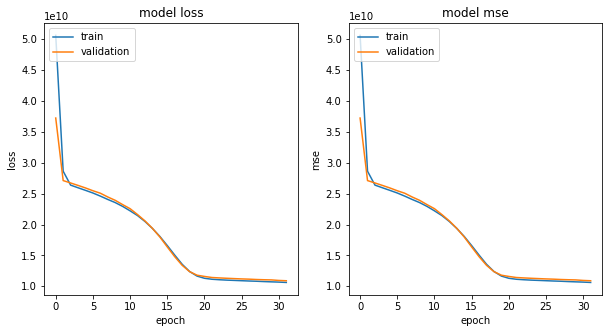

In [55]:
plot_curves(history, ["loss", "mse"])

Next we create a predition model.

In [56]:
model.predict({
    "longitude": tf.convert_to_tensor([-122.43]),
    "latitude": tf.convert_to_tensor([37.63]),
    "housing_median_age": tf.convert_to_tensor([34.0]),
    "total_rooms": tf.convert_to_tensor([4135.0]),
    "total_bedrooms": tf.convert_to_tensor([687.0]),
    "population": tf.convert_to_tensor([2154.0]),
    "households": tf.convert_to_tensor([742.0]),
    "median_income": tf.convert_to_tensor([4.9732]),
    "ocean_proximity": tf.convert_to_tensor(["NEAR OCEAN"])
})

Consider rewriting this model with the Functional API.


array([[232037.58]], dtype=float32)

### **Analysis**

The model returns a predicted value. Compare this value to the test set you ran earlier. Predicted value may be a bit better.